In [1]:
import itertools
import math
import numpy as np

import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

from accelerate import Accelerator
from accelerate.logging import get_logger

from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import requests
import glob
from io import BytesIO
import os
import random
from PIL import Image
from tqdm.auto import tqdm

from torchvision import transforms

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.2.2+cu121 with CUDA 1201 (you have 2.2.2+cu118)
    Python  3.10.11 (you have 3.10.9)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # 

In [2]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [3]:
pretrained_model = "stabilityai/stable-diffusion-2"

In [19]:
data_path ="../../datasets/imagenet-mini/train"
class_name = "001"

save_path = "textual_inversion_weights"
os.makedirs(os.path.join(save_path, class_name), exist_ok=True)

In [6]:
images = []
for img_path in os.listdir(os.path.join(data_path, class_name)):
    img = Image.open(os.path.join(data_path, class_name, img_path))
    images.append(Image.open(os.path.join(data_path, class_name, img_path)).resize((512, 512)))

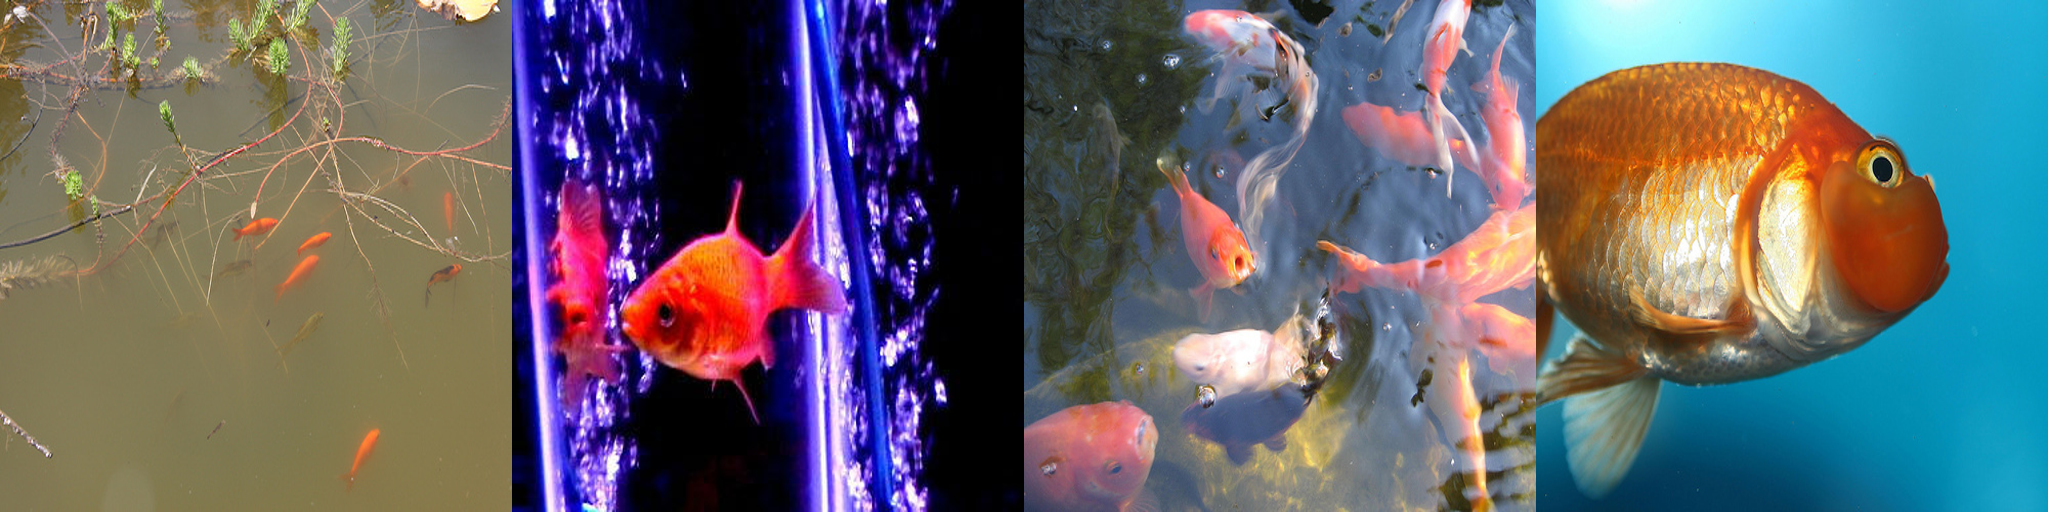

In [7]:
image_grid(images[:4], 1, 4)

In [9]:
what_to_teach = "object"
placeholder_token = "<001>"
initializer_token = "goldfish"

In [10]:
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [11]:
class TextualInversionDataset(Dataset):
    def __init__(self, data_root, tokenizer, learnable_property="object", size=512, repeats=100, interpolation="bicubic", flip_p=0.5, set="train", placeholder_token="*", center_crop=False):
        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            # "linear": Image.LINEAR,
            "bilinear": Image.BILINEAR,
            "bicubic": Image.BICUBIC,
            "lanczos": Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)
    
    def __len__(self):
        return self._length
    
    def __getitem__(self, index):
        example = {}
        image = Image.open(self.image_paths[index % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [12]:
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model,
    subfolder="tokenizer"
)

num_added_tokens = tokenizer.add_tokens(placeholder_token)

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adity\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

In [13]:
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [14]:
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model, subfolder="unet"
)

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

In [15]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 1024)

In [16]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [17]:
def freeze_params(params):
    for p in params:
        p.requires_grad = False

In [18]:
freeze_params(vae.parameters())
freeze_params(unet.parameters())

params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [20]:
train_dataset = TextualInversionDataset(
    data_root=os.path.join(data_path, class_name),
    tokenizer=tokenizer,
    size=vae.sample_size,
    placeholder_token=placeholder_token,
    repeats=100,
    learnable_property=what_to_teach,
    center_crop=False,
    set="train",
)

C:\Users\adity\AppData\Local\Temp\ipykernel_15540\3302588838.py:4: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  size=vae.sample_size,
C:\Users\adity\AppData\Local\Temp\ipykernel_15540\2002465120.py:21: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  "bilinear": Image.BILINEAR,
C:\Users\adity\AppData\Local\Temp\ipykernel_15540\2002465120.py:22: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  "bicubic": Image.BICUBIC,
C:\Users\adity\AppData\Local\Temp\ipykernel_15540\2002465120.py:23: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  "lanczos": Image.LANCZOS,


In [21]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

In [22]:
noise_scheduler = DDPMScheduler.from_config(pretrained_model, subfolder="scheduler")

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\configuration_utils.py:244: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

c:\Users\adity\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [23]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 2000,
    "save_steps": 250,
    "train_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "gradient_checkpointing": True,
    "mixed_precision": "fp16",
    "seed": 42,
    "output_dir": f"textual_inversion_weights/{class_name}",
}

In [24]:
def save_progress(text_encoder, placeholder_token_id, accelerator, save_path):
    learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
    learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
    torch.save(learned_embeds_dict, save_path)

In [25]:
def training_function(text_encoder, vae, unet):
    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]
    gradient_checkpointing = hyperparameters["gradient_checkpointing"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=hyperparameters["mixed_precision"]
    )

    if gradient_checkpointing:
        text_encoder.gradient_checkpointing_enable()
        unet.enable_gradient_checkpointing()

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes)
    
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),
        lr=learning_rate,
    )

    text_encoder, optimizer, train_dataloader = accelerator.prepare(text_encoder, optimizer, train_dataloader)

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
    
    vae.to(accelerator.device, dtype=weight_dtype)
    unet.to(accelerator.device, dtype=weight_dtype)

    vae.eval()
    unet.train()

    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for e in range(num_train_epochs):
        text_encoder.train()

        for s, b in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                latents = vae.encode(b["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample().detach()
                latents = latents * 0.18215

                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
                encoder_hidden_states = text_encoder(b["input_ids"])[0]
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states.to(weight_dtype)).sample

                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                
                loss = F.mse_loss(noise_pred, target, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad

                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1
                if global_step % hyperparameters["save_steps"] == 0:
                    save_path = os.path.join(output_dir, f"learned_embeds-step-{global_step}.bin")
                    save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break
        
        accelerator.wait_for_everyone()
    
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model,
            text_encoder=accelerator.unwrap_model(text_encoder),
            tokenizer=tokenizer,
            vae=vae,
            unet=unet,
        )
        pipeline.save_pretrained(output_dir)
        
        # Also save the newly trained embeddings
        save_path = os.path.join(output_dir, f"learned_embeds.bin")
        save_progress(text_encoder, placeholder_token_id, accelerator, save_path)

In [ ]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes=1)

for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
    if param.grad is not None:
        del param.grad  # free some memory
    torch.cuda.empty_cache()